# Chargement des libs

In [69]:
import sys
import os
import logging
import pandas as pd
import numpy as np
import json
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
import warnings

warnings.filterwarnings('ignore')

logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )
logger = logging.getLogger(__name__)

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils import clusters

# Collecte de données

In [70]:
db_path = "../data/xenty.db"
conn = sqlite3.connect(db_path)
query = "SELECT * FROM x_cryptos ORDER BY CASE WHEN market_cap_rank IS NULL THEN 999999 ELSE market_cap_rank END ASC"

df = pd.read_sql_query(query, conn)
conn.close()
print("📊 Dataset créé avec", len(df), "comptes crypto")
df.head()

📊 Dataset créé avec 7980 comptes crypto


,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7788378,13,28585,"{""tweet-1942338245737492607"": {""created_at"": ""...",1313643968,1.0,1.751933e+09
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3847295,0,4299,"{""tweet-1942319838808138185"": {""created_at"": ""...",1390763724,2.0,1.751934e+09
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,537857,246,1755,"{""tweet-1938132804270739805"": {""created_at"": ""...",1415394150,3.0,NaN
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3146294,986,9103,"{""tweet-1938276067502133466"": {""created_at"": ""...",1356983139,4.0,NaN
4,1052454006537314306,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3848162,627,26821,"{""tweet-1938269416271061330"": {""created_at"": ""...",1539759563,5.0,NaN


# Nettoyage et préparation des données

In [71]:
# Fonction pour modifier le type de l'attribut views_count string -> int
def cast_views_count_to_int(post_json_str):
    if pd.isna(post_json_str):
        return post_json_str
    
    # Charger le JSON
    try:
        posts_dict = json.loads(post_json_str)
    except json.JSONDecodeError:
        # Si le JSON est invalide, retourner la valeur originale
        return post_json_str
    
    # Parcourir chaque tweet dans le dictionnaire
    for _, tweet_data in posts_dict.items():
        if 'views_count' in tweet_data:
            tweet_data['views_count'] = int(tweet_data.pop('views_count'))
    
    # Reconvertir en JSON string
    return json.dumps(posts_dict)

# Appliquer la fonction à la colonne posts
print("Début de la transformation...")
posts_before = json.loads(df.loc[0, 'posts'])
keys = posts_before.keys()
first_key = list(keys)[0] if keys else None
print(posts_before[first_key])
df['posts'] = df['posts'].apply(cast_views_count_to_int)
posts_after = json.loads(df.loc[0, 'posts'])
keys = posts_after.keys()
first_key = list(keys)[0] if keys else None
print(posts_after[first_key])
print("Transformation terminée!")

# Remplacer les valeurs manquantes par -1 et convertir en int
df['market_cap_rank'] = df['market_cap_rank'].fillna(-1).astype(int)
df['sync_at'] = df['sync_at'].fillna(0).astype(int)
df.tail()

Début de la transformation...
{'created_at': 'Mon Jul 07 21:41:39 +0000 2025', 'full_text': '$108,034.81', 'views_count': '49936', 'bookmark_count': 6, 'likes_count': 610, 'quote_count': 11, 'reply_count': 169, 'retweet_count': 111, 'comments': ['@Bitcoin Higher!!!!', '@Bitcoin bro we have access to charts chill', '@Bitcoin $180,000 is coming', '@Bitcoin MOON', '@Bitcoin Up up up dance dance 😂', '@Bitcoin BTC DOMINATION https://t.co/PSV74mv8LB', '@Bitcoin Hell yeah!! https://t.co/gFWwghCq7F', '@Bitcoin bc1qe9vmfy8avz4sxx39pf0n4fqunhz2eghdqygf8w', '@Bitcoin Is bro predicting ETH price in 2026?', '@Bitcoin $120,000.00']}
{'created_at': 'Mon Jul 07 21:41:39 +0000 2025', 'full_text': '$108,034.81', 'bookmark_count': 6, 'likes_count': 610, 'quote_count': 11, 'reply_count': 169, 'retweet_count': 111, 'comments': ['@Bitcoin Higher!!!!', '@Bitcoin bro we have access to charts chill', '@Bitcoin $180,000 is coming', '@Bitcoin MOON', '@Bitcoin Up up up dance dance 😂', '@Bitcoin BTC DOMINATION htt

,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at
7975,1932619199731675136,CoinElonSolana,CoinElonSolana,,0,21,0,1,None,1749607321,-1,0
7976,1933488137613025280,Commentary ShibEstee,TheEsteeCoin,$ESTEE: The original $SHIB. The fan Meme coin ...,0,1659,135,102,None,1749814490,-1,0
7977,1934669424239497216,roadmap coin,roadmapcoin,$RDMP is the coin of empty promises on @boopdo...,0,534,3,35,None,1750096124,-1,0
7978,1935243794250690560,Trevee Quest (Prev. Paladin_vote),Paladin_vote,@Trevee_xyz,0,4,2,0,None,1750233055,-1,0
7979,1937579523253665792,ImmortalDAO Finance,ImmortalDAO_Fi,Immortal is a decentralized reserve currency p...,0,1,2,1,None,1750789942,-1,0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7980 entries, 0 to 7979
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                7980 non-null   object
 1   name              7979 non-null   object
 2   screen_name       7980 non-null   object
 3   description       7980 non-null   object
 4   is_blue_verified  7980 non-null   int64 
 5   followers_count   7980 non-null   int64 
 6   following_count   7980 non-null   int64 
 7   posts_count       7980 non-null   int64 
 8   posts             1004 non-null   object
 9   created_at        7980 non-null   int64 
 10  market_cap_rank   7980 non-null   int64 
 11  sync_at           7980 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 748.3+ KB


In [73]:
# Suppression des comptes sans posts
df = df.dropna(subset=['posts']).reset_index(drop=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1004 non-null   object
 1   name              1004 non-null   object
 2   screen_name       1004 non-null   object
 3   description       1004 non-null   object
 4   is_blue_verified  1004 non-null   int64 
 5   followers_count   1004 non-null   int64 
 6   following_count   1004 non-null   int64 
 7   posts_count       1004 non-null   int64 
 8   posts             1004 non-null   object
 9   created_at        1004 non-null   int64 
 10  market_cap_rank   1004 non-null   int64 
 11  sync_at           1004 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 94.3+ KB


,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7788378,13,28585,"{""tweet-1942338245737492607"": {""created_at"": ""...",1313643968,1,1751932985
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3847295,0,4299,"{""tweet-1942319838808138185"": {""created_at"": ""...",1390763724,2,1751933908
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,537857,246,1755,"{""tweet-1938132804270739805"": {""created_at"": ""...",1415394150,3,0
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3146294,986,9103,"{""tweet-1938276067502133466"": {""created_at"": ""...",1356983139,4,0
4,1052454006537314306,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3848162,627,26821,"{""tweet-1938269416271061330"": {""created_at"": ""...",1539759563,5,0


In [74]:
df_filtered = df.copy()

# Filtre les tweets invalides
"""
Supprimer les retweets/repost car pas d'informations sur les interactions
Permet la mesure des interactions avec contenu original.
Supprimer les tweets sans views_count mais avec interactions
"""
def filter_valid_tweets(posts_json):
    posts_dict = json.loads(posts_json)
    
    filtered = {}
    for tweet_id, tweet_data in posts_dict.items():
        if (tweet_data.get('likes_count', 0) == 0 and 
            tweet_data.get('quote_count', 0) == 0 and 
            tweet_data.get('reply_count', 0) == 0) or (
                tweet_data.get('views_count', 0) == 0 and 
                (tweet_data.get('reply_count', 0) != 0 or 
                tweet_data.get('retweet_count', 0) != 0 or 
                tweet_data.get('likes_count', 0) != 0)) :
            continue
        filtered[tweet_id] = tweet_data
    
    return filtered

# Appliquer le filtre
df_filtered["filtered_posts"] = df_filtered["posts"].apply(filter_valid_tweets)
# df_filtered.drop(columns=["posts"], inplace=True)
#print(df["filtered_posts"])

# posts = df_filtered.loc[0, 'filtered_posts']
# print(len(posts))

# Calculer le nombre de tweets dans chaque entrée de posts
tweet_counts_original = df_filtered['posts'].apply(lambda x: len(json.loads(x)))
tweet_counts_filtered = df_filtered['filtered_posts'].apply(lambda x: len(x))

df_filtered['tweet_counts_original'] = tweet_counts_original
df_filtered['tweet_counts_filtered'] = tweet_counts_filtered

# Remove all row with tweet_counts_filtered = 0
df_filtered = df_filtered[df_filtered['tweet_counts_filtered'] > 0].reset_index(drop=True)

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965 entries, 0 to 964
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     965 non-null    object
 1   name                   965 non-null    object
 2   screen_name            965 non-null    object
 3   description            965 non-null    object
 4   is_blue_verified       965 non-null    int64 
 5   followers_count        965 non-null    int64 
 6   following_count        965 non-null    int64 
 7   posts_count            965 non-null    int64 
 8   posts                  965 non-null    object
 9   created_at             965 non-null    int64 
 10  market_cap_rank        965 non-null    int64 
 11  sync_at                965 non-null    int64 
 12  filtered_posts         965 non-null    object
 13  tweet_counts_original  965 non-null    int64 
 14  tweet_counts_filtered  965 non-null    int64 
dtypes: int64(9), object(6)


In [75]:
# Statistiques descriptives
stats_df = pd.DataFrame({
    'Posts originaux': df['posts'].apply(lambda x: len(json.loads(x))).describe(),
    'Posts filtrés': df_filtered['tweet_counts_filtered'].describe()
})
print("Statistiques sur le nombre de tweets par entrée:")
display(stats_df)

# Calculer la réduction moyenne du nombre de tweets après filtrage
reduction = ((tweet_counts_original - tweet_counts_filtered) / tweet_counts_original * 100).mean()
print(f"Réduction moyenne du nombre de tweets après filtrage: {reduction:.2f}%")
df_filtered.head()

Statistiques sur le nombre de tweets par entrée:


,Posts originaux,Posts filtrés
count,1004.00000,965.000000
mean,15.24502,10.756477
std,4.88346,5.372414
min,1.00000,1.000000
25%,13.00000,6.000000
50%,17.00000,11.000000
75%,19.00000,15.000000
max,20.00000,20.000000


Réduction moyenne du nombre de tweets après filtrage: 32.74%


,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at,filtered_posts,tweet_counts_original,tweet_counts_filtered
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7788378,13,28585,"{""tweet-1942338245737492607"": {""created_at"": ""...",1313643968,1,1751932985,{'tweet-1942338245737492607': {'created_at': '...,20,19
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3847295,0,4299,"{""tweet-1942319838808138185"": {""created_at"": ""...",1390763724,2,1751933908,{'tweet-1939792963657257455': {'created_at': '...,17,5
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,537857,246,1755,"{""tweet-1938132804270739805"": {""created_at"": ""...",1415394150,3,0,{'tweet-1936333412077322739': {'created_at': '...,20,5
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3146294,986,9103,"{""tweet-1938276067502133466"": {""created_at"": ""...",1356983139,4,0,{'tweet-1938221710391587076': {'created_at': '...,20,6
4,1052454006537314306,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3848162,627,26821,"{""tweet-1938269416271061330"": {""created_at"": ""...",1539759563,5,0,{'tweet-1938269324575187353': {'created_at': '...,13,9


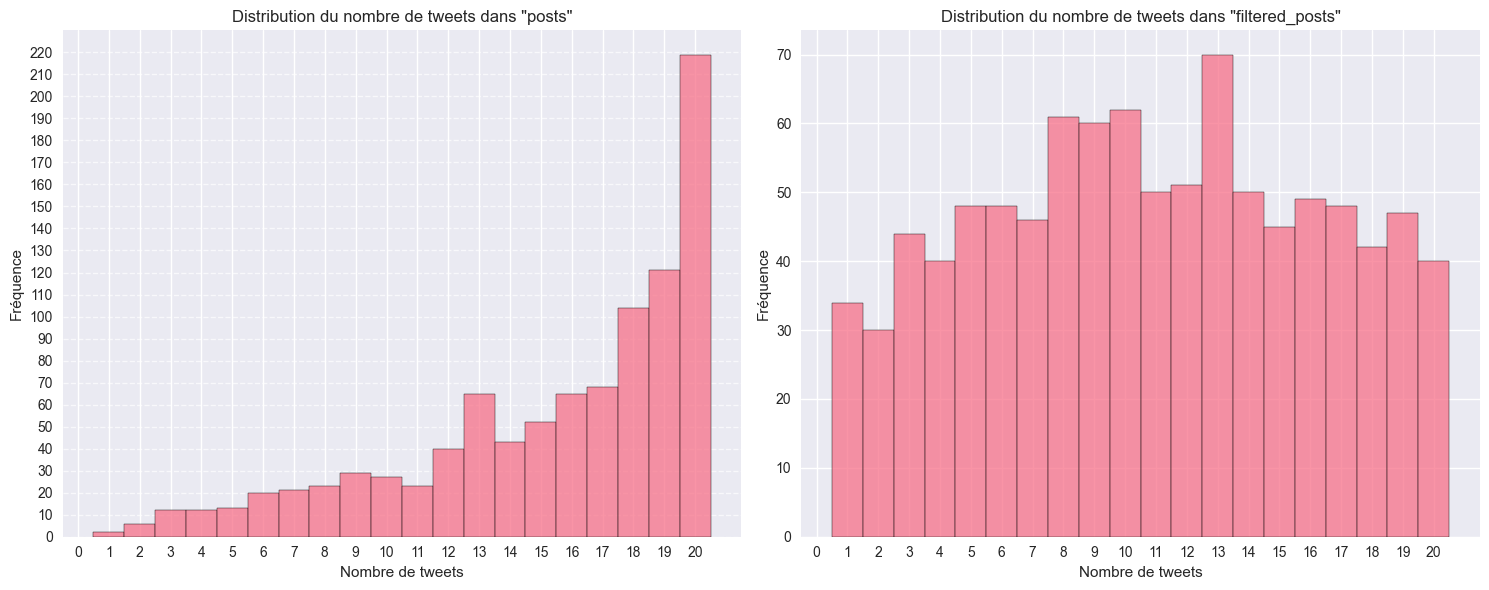

In [76]:
# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Déterminer la plage des données pour définir les bins
max_count = max(df_filtered['tweet_counts_original'].max(), df_filtered['tweet_counts_filtered'].max())
bins = np.arange(-0.5, max_count + 1.5, 1)  # Bins centrés sur les entiers

# Créer une figure avec deux sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogramme pour les posts initiaux
sns.histplot(df_filtered['tweet_counts_original'], bins=bins, kde=False, ax=axes[0], discrete=True)
axes[0].set_title('Distribution du nombre de tweets dans "posts"')
axes[0].set_xlabel('Nombre de tweets')
axes[0].set_ylabel('Fréquence')
axes[0].set_xticks(np.arange(0, max_count + 1, 1))  # Ticks entiers

# Amélioration de la précision de l'axe vertical
y_max = axes[0].get_ylim()[1]
axes[0].set_yticks(np.arange(0, int(y_max) + 1, 10))  # Ticks entiers pour chaque valeur de fréquence
axes[0].grid(axis='y', linestyle='--', alpha=0.7)  # Ajouter une grille horizontale

# Histogramme pour les posts filtrés
sns.histplot(df_filtered['tweet_counts_filtered'], bins=bins, kde=False, ax=axes[1], discrete=True)
axes[1].set_title('Distribution du nombre de tweets dans "filtered_posts"')
axes[1].set_xlabel('Nombre de tweets')
axes[1].set_ylabel('Fréquence')
axes[1].set_xticks(np.arange(0, max_count + 1, 1))  # Ticks entiers

# Si le max_count est grand, limitons les ticks pour éviter l'encombrement
if max_count > 20:
    for ax in axes:
        ax.set_xticks(np.arange(0, max_count + 1, 2))  # Ticks tous les 2 entiers

plt.tight_layout()
plt.show()

## Normalisation des données

In [77]:
def calculate_view_normalized_metric(posts, metric_name):
    """
    Calculates the rate of a metric relative to the total number of views.
    """
    if not posts:
        return 0
    
    total_metric = sum(post.get(metric_name, 0) for post in posts.values())
    total_views = sum(post.get('views_count', 0) for post in posts.values())
    
    if total_views == 0:
        return 0
    
    return total_metric / total_views
    
# Create the new view-normalized feature columns
df_filtered['likes_per_views'] = df_filtered['filtered_posts'].apply(lambda x: calculate_view_normalized_metric(x, 'likes_count'))
df_filtered['retweets_per_views'] = df_filtered['filtered_posts'].apply(lambda x: calculate_view_normalized_metric(x, 'retweet_count'))
df_filtered['replies_per_views'] = df_filtered['filtered_posts'].apply(lambda x: calculate_view_normalized_metric(x, 'reply_count'))
df_filtered.head()

,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at,filtered_posts,tweet_counts_original,tweet_counts_filtered,likes_per_views,retweets_per_views,replies_per_views
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7788378,13,28585,"{""tweet-1942338245737492607"": {""created_at"": ""...",1313643968,1,1751932985,{'tweet-1942338245737492607': {'created_at': '...,20,19,0.013006,0.003842,0.001966
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3847295,0,4299,"{""tweet-1942319838808138185"": {""created_at"": ""...",1390763724,2,1751933908,{'tweet-1939792963657257455': {'created_at': '...,17,5,0.009052,0.001494,0.000736
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,537857,246,1755,"{""tweet-1938132804270739805"": {""created_at"": ""...",1415394150,3,0,{'tweet-1936333412077322739': {'created_at': '...,20,5,0.003922,0.000672,0.000759
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3146294,986,9103,"{""tweet-1938276067502133466"": {""created_at"": ""...",1356983139,4,0,{'tweet-1938221710391587076': {'created_at': '...,20,6,0.013310,0.003412,0.000577
4,1052454006537314306,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3848162,627,26821,"{""tweet-1938269416271061330"": {""created_at"": ""...",1539759563,5,0,{'tweet-1938269324575187353': {'created_at': '...,13,9,0.005952,0.001455,0.004204


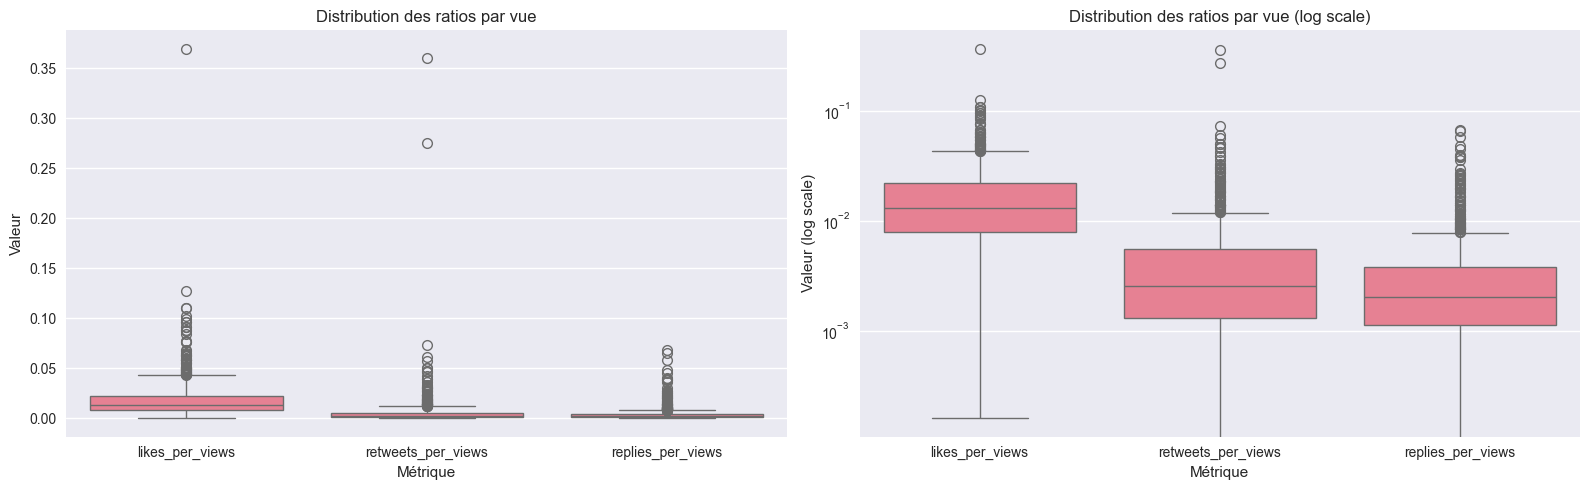

In [78]:
# Transformation du dataframe en format long
df_melted = df_filtered[['likes_per_views', 'retweets_per_views', 'replies_per_views']].melt(var_name='metric', value_name='value')

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Premier graphique (échelle normale)
sns.boxplot(data=df_melted, x='metric', y='value', ax=axes[0])
axes[0].set_title("Distribution des ratios par vue")
axes[0].set_xlabel("Métrique")
axes[0].set_ylabel("Valeur")

# Deuxième graphique (échelle logarithmique)
sns.boxplot(data=df_melted, x='metric', y='value', ax=axes[1])
axes[1].set_title("Distribution des ratios par vue (log scale)")
axes[1].set_xlabel("Métrique")
axes[1].set_ylabel("Valeur (log scale)")
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()


Nombre d'outliers détectés (IQR): 139
Dataset nettoyé: 826 lignes sur 965 originales


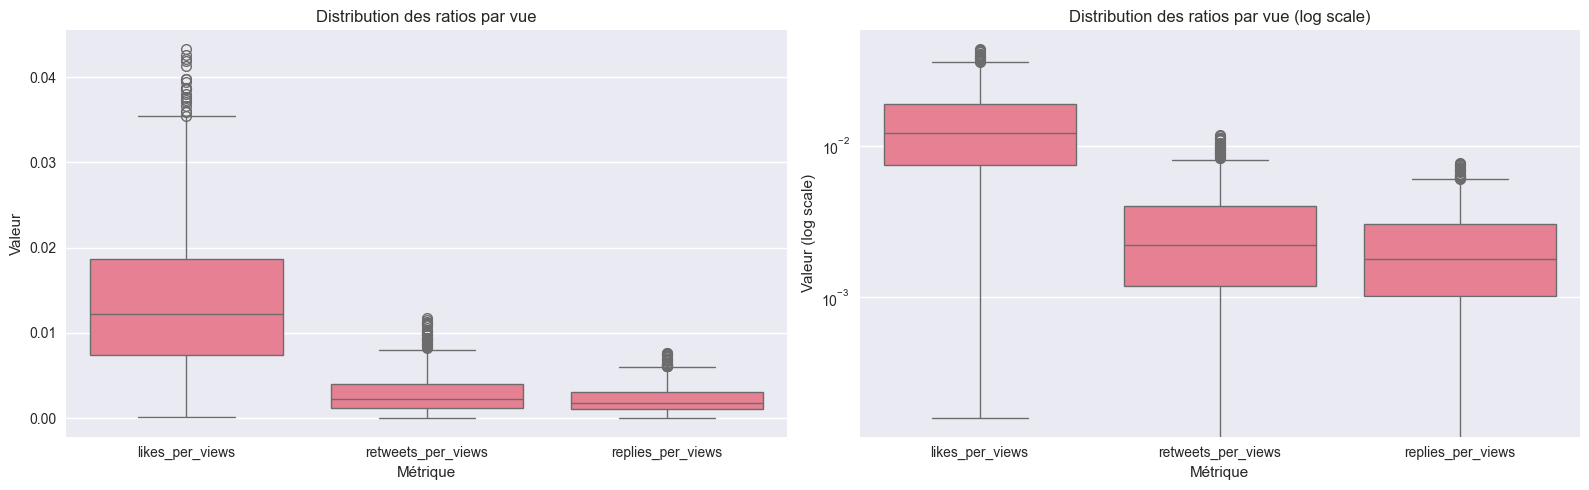

In [79]:
# Suppression des valeurs abérrantes
def remove_outliers(df_iqr, columns, lower_quantile=0.25, upper_quantile=0.75):
    # Calculer les quantiles sur les colonnes spécifiées
    Q1 = df_iqr[columns].quantile(lower_quantile)
    Q3 = df_iqr[columns].quantile(upper_quantile)
    IQR = Q3 - Q1
    
    # Créer le masque d'outliers en s'assurant de l'alignement
    subset_df = df_iqr[columns]  # Extraire uniquement les colonnes d'intérêt
    
    # Conditions d'outliers alignées
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifier les outliers (vectorisé et aligné)
    is_outlier = ((subset_df < lower_bound) | (subset_df > upper_bound)).any(axis=1)
    
    # Supprimer les outliers du DataFrame complet
    df_clean_iqr = df_iqr[~is_outlier].reset_index(drop=True)
    
    print(f"Nombre d'outliers détectés (IQR): {is_outlier.sum()}")
    print(f"Dataset nettoyé: {len(df_clean_iqr)} lignes sur {len(df_iqr)} originales")
    
    return df_clean_iqr

# Remove outliers from engagement_rate
df_clean_iqr = remove_outliers(df_filtered, [
    'likes_per_views',
    'retweets_per_views',
    'replies_per_views'])

# Transformation du dataframe en format long
df_melted = df_clean_iqr[['likes_per_views', 'retweets_per_views', 'replies_per_views']].melt(var_name='metric', value_name='value')

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Premier graphique (échelle normale)
sns.boxplot(data=df_melted, x='metric', y='value', ax=axes[0])
axes[0].set_title("Distribution des ratios par vue")
axes[0].set_xlabel("Métrique")
axes[0].set_ylabel("Valeur")

# Deuxième graphique (échelle logarithmique)
sns.boxplot(data=df_melted, x='metric', y='value', ax=axes[1])
axes[1].set_title("Distribution des ratios par vue (log scale)")
axes[1].set_xlabel("Métrique")
axes[1].set_ylabel("Valeur (log scale)")
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()


# Sélection de l'algorithme et du modèle


📈 Features d'engagement créées:
       likes_per_views  retweets_per_views  replies_per_views
count       826.000000          826.000000         826.000000
mean          0.013842            0.002998           0.002220
std           0.008750            0.002517           0.001623
min           0.000160            0.000000           0.000000
25%           0.007450            0.001185           0.001017
50%           0.012165            0.002204           0.001785
75%           0.018652            0.004005           0.003027
max           0.043334            0.011751           0.007634


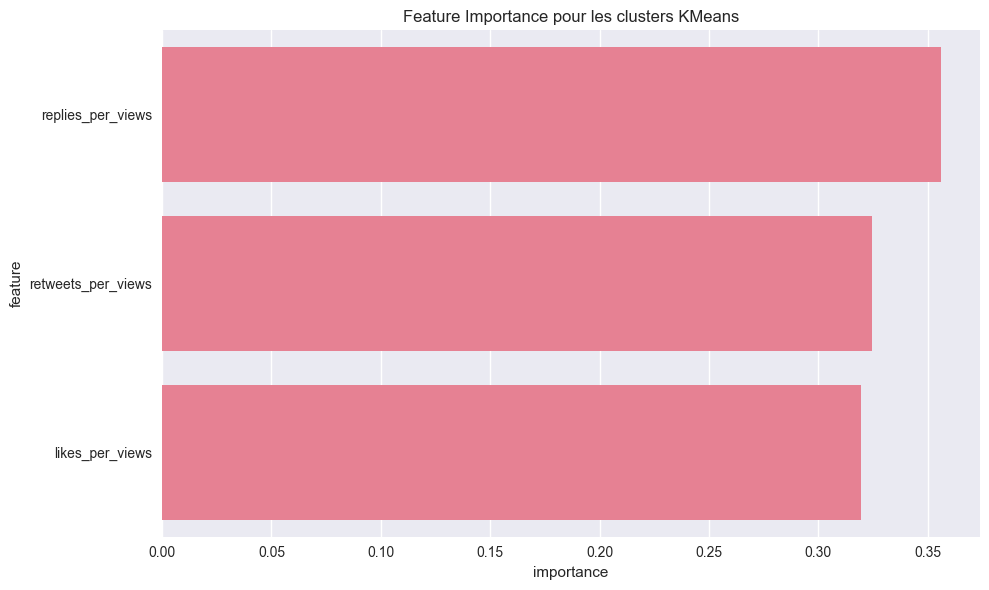

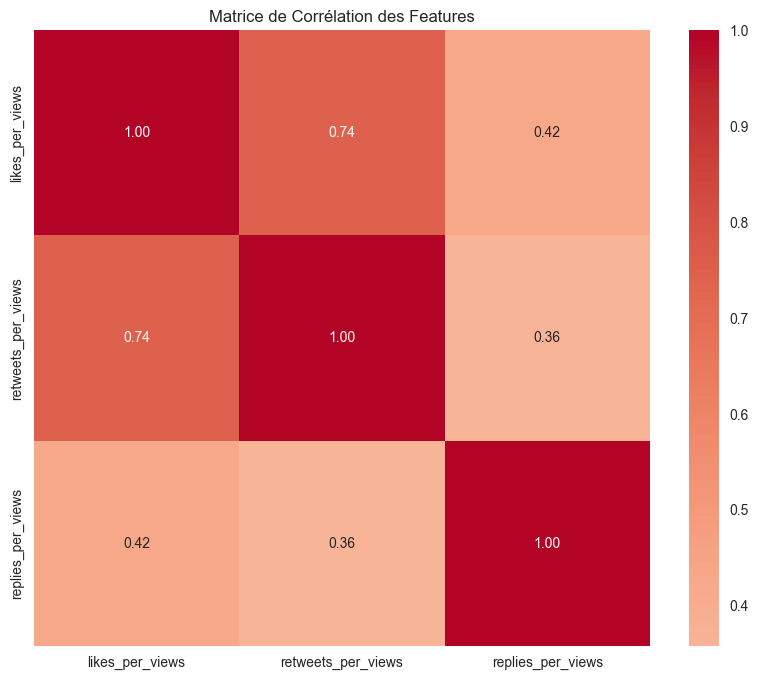

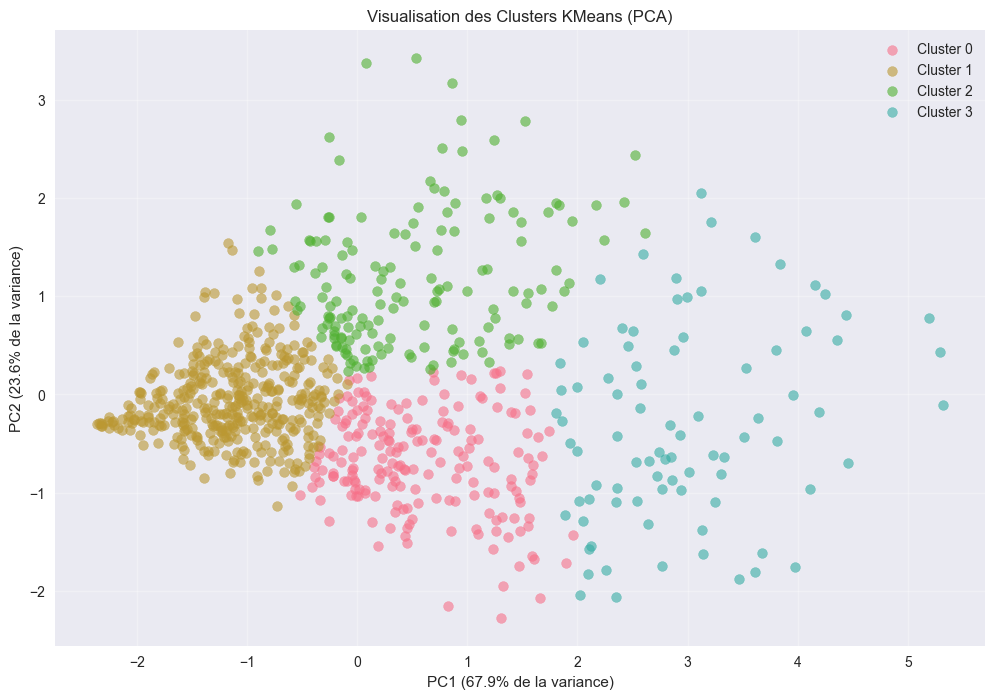

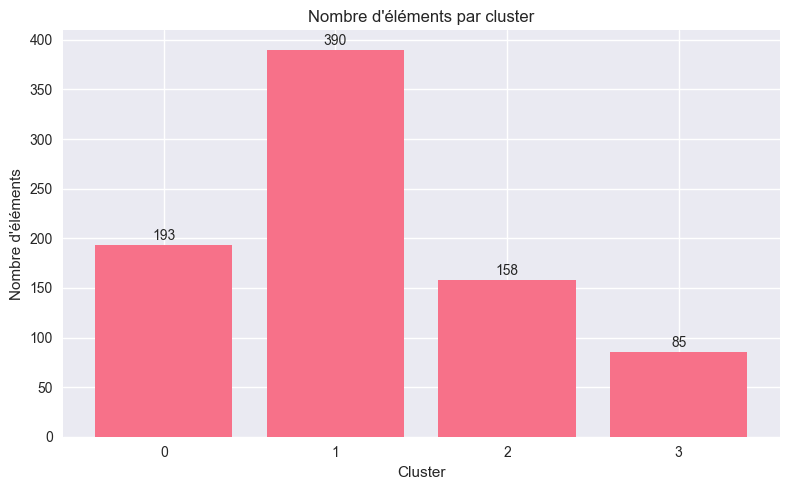

In [80]:
df_features = df_clean_iqr.copy()

features = [
    # 'followers_count',
    # 'following_count',
    # 'posts_count',
    # 'market_cap_rank',    
    # 'tweet_counts_filtered',
    # 'likes_per_follower',
    # 'retweets_per_follower',
    # 'replies_per_follower',
    # 'views_per_follower',
    'likes_per_views',
    'retweets_per_views',
    'replies_per_views'
]

print("\n📈 Features d'engagement créées:")
print(df_features[features].describe())

n_clusters = 4

# Extraction des caractéristiques
X = df_features[features]

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Effectuer le clustering KMeans
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(X_scaled)

# Ajouter les clusters au DataFrame original
df_features["cluster"] = cluster_labels

# Calculer l'importance des features via RandomForest sur les clusters
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_scaled, cluster_labels)
importances_f = rf_model.feature_importances_

# Créer un DataFrame pour visualiser l'importance des features
feature_importance_df = pd.DataFrame({
    "feature": features,
    "importance": importances_f
}).sort_values(by="importance", ascending=False)

# Visualiser l'importance des features
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importance_df)
plt.title("Feature Importance pour les clusters KMeans")
plt.tight_layout()
plt.show()

# Matrice de corrélation
plt.figure(figsize=(10, 8))
correlation_matrix = df_features[features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Matrice de Corrélation des Features')
plt.show()

# Visualiser les clusters avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    mask = df_features['cluster'] == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               label=f'Cluster {i}', alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} de la variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} de la variance)')
plt.title('Visualisation des Clusters KMeans (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

cluster_counts = df_features['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
plt.bar(range(len(cluster_counts)), cluster_counts.values)
plt.title('Nombre d\'éléments par cluster')
plt.xticks(range(len(cluster_counts)), cluster_counts.index)
plt.xlabel('Cluster')
plt.ylabel('Nombre d\'éléments')
for i, count in enumerate(cluster_counts.values):
    plt.text(i, count + 5, str(count), ha='center')
plt.tight_layout()
plt.show()

# Evaluation du modèle

In [81]:
# Analyse des clusters
print(f"\n🎯 Résultats du clustering (k={n_clusters}):")
cluster_means = df_features.groupby('cluster')[features].mean()
print("\n📋 Profil moyen des clusters:")
cluster_means


🎯 Résultats du clustering (k=4):

📋 Profil moyen des clusters:


,likes_per_views,retweets_per_views,replies_per_views
cluster,,,
0,0.019312,0.004405,0.001665
1,0.007534,0.001348,0.001269
2,0.014326,0.002499,0.004241
3,0.029467,0.008304,0.004089


In [88]:
cluster_dfs = {}
for k in range(n_clusters):
    cluster_dfs[f'Cluster {k}'] = df_features[df_features['cluster'] == k]['screen_name'].reset_index(drop=True)
display(pd.concat(cluster_dfs, axis=1).head(10))

display(df_features[df_features['name'] == 'Bitcoin'][
    ['screen_name', 'cluster'] + [f for f in features]
])


,Cluster 0,Cluster 1,Cluster 2,Cluster 3
0,Bitcoin,ethereum,BNBCHAIN,eth_classic
1,Ripple,Tether_to,trondao,RealFlokiInu
2,chainlink,solana,bitgetglobal,OnyxDAO
3,StellarOrg,circle,Uniswap,BuildOnBeam
4,avax,dogecoin,Aptos,BabyDogeCoin
5,hedera,Cardano,okx,Toshi_base
6,PiCoreTeam,HyperliquidX,NEARProtocol,Sia__Foundation
7,pepecoineth,bitfinex,cronos_chain,fasttoken_com
8,dfinity,Shibtoken,kucoincom,BeldexCoin
9,0xMantle,litecoin,KaiaChain,LegacyNetworkio


,screen_name,cluster,likes_per_views,retweets_per_views,replies_per_views
0,Bitcoin,0,0.013006,0.003842,0.001966


## Labelisation

- `Cluster 0` - `Engagement Équilibré`

    Profils avec un engagement modéré et bien réparti entre likes, retweets et replies.
    
    Représentent probablement des comptes crypto généralistes avec une audience stable.
    

- `Cluster 1` - `Forte Attraction`

    Comptes générant beaucoup de likes mais peu de replies, suggérant un contenu populaire mais moins propice au débat.
    
    Probablement des comptes de news crypto ou d'influenceurs.


- `Cluster 2` - `Faible Engagement`

    Profils avec les ratios d'engagement les plus bas sur tous les indicateurs.
    
    Possiblement des comptes dormants, bots, ou comptes avec un contenu peu engageant.


- `Cluster 3` - `Haute Viralité`

    Comptes avec les ratios d'engagement les plus élevés, particulièrement en retweets.
    
    Probablement des comptes d'actualités crypto, d'analyses ou de contenus très partagés par la communauté.

In [83]:
# Chargement dynamique du dictionnaire
cluster_dict = getattr(clusters, f'engagement_clusters_{n_clusters}', None)

if cluster_dict is None:
    raise ValueError(f"Aucun dictionnaire trouvé pour {n_clusters} clusters")

def assign_engagement_labels(df_clustered):
    """
    Ajoute une colonne 'engagement_level' au DataFrame avec les labels correspondants aux clusters
    """

    # Créer une copie du DataFrame pour éviter de modifier l'original
    result_df = df_clustered.copy()
    
    # Ajouter la colonne engagement_level
    result_df['engagement_level'] = result_df['cluster'].apply(
        lambda x: cluster_dict.get(x, {}).get("cluster_label", "Cluster Inconnu")
    )
    
    return result_df

df_features = assign_engagement_labels(df_features)

df_features.head()

,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at,filtered_posts,tweet_counts_original,tweet_counts_filtered,likes_per_views,retweets_per_views,replies_per_views,cluster,engagement_level
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7788378,13,28585,"{""tweet-1942338245737492607"": {""created_at"": ""...",1313643968,1,1751932985,{'tweet-1942338245737492607': {'created_at': '...,20,19,0.013006,0.003842,0.001966,0,Engagement Équilibré
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3847295,0,4299,"{""tweet-1942319838808138185"": {""created_at"": ""...",1390763724,2,1751933908,{'tweet-1939792963657257455': {'created_at': '...,17,5,0.009052,0.001494,0.000736,1,Forte Attraction
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,537857,246,1755,"{""tweet-1938132804270739805"": {""created_at"": ""...",1415394150,3,0,{'tweet-1936333412077322739': {'created_at': '...,20,5,0.003922,0.000672,0.000759,1,Forte Attraction
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3146294,986,9103,"{""tweet-1938276067502133466"": {""created_at"": ""...",1356983139,4,0,{'tweet-1938221710391587076': {'created_at': '...,20,6,0.013310,0.003412,0.000577,0,Engagement Équilibré
4,1052454006537314306,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3848162,627,26821,"{""tweet-1938269416271061330"": {""created_at"": ""...",1539759563,5,0,{'tweet-1938269324575187353': {'created_at': '...,13,9,0.005952,0.001455,0.004204,2,Faible Engagement


In [84]:
# ANALYSE DES COMPTES REPRÉSENTATIFS
 
print("\n🔍 ANALYSE DES COMPTES REPRÉSENTATIFS:")

engagement_clusters = [v["cluster_label"] for v in cluster_dict.values()]

for engagement_level in engagement_clusters:
    print(f"\n--- {engagement_level.upper()} ---")
    subset = df_features[df_features['engagement_level'] == engagement_level]
    
    # Statistiques du groupe
    print(f"Nombre de comptes: {len(subset)}")
    print(f"Followers moyen: {subset['followers_count'].mean():.0f}")
    
    # Top 3 comptes du groupe
    top_accounts = subset.nlargest(3, 'cluster')[
        ['screen_name', 'followers_count'] + [f for f in features]
    ]
    print("Top 3 comptes:")
    print(top_accounts.to_string(index=False))


🔍 ANALYSE DES COMPTES REPRÉSENTATIFS:

--- ENGAGEMENT ÉQUILIBRÉ ---
Nombre de comptes: 193
Followers moyen: 287544
Top 3 comptes:
screen_name  followers_count  likes_per_views  retweets_per_views  replies_per_views
    Bitcoin          7788378         0.013006            0.003842           0.001966
     Ripple          3146294         0.013310            0.003412           0.000577
  chainlink          1328955         0.020288            0.003229           0.001166

--- FORTE ATTRACTION ---
Nombre de comptes: 390
Followers moyen: 655928
Top 3 comptes:
screen_name  followers_count  likes_per_views  retweets_per_views  replies_per_views
   ethereum          3847295         0.009052            0.001494           0.000736
  Tether_to           537857         0.003922            0.000672           0.000759
     solana          3445919         0.005430            0.000678           0.001324

--- FAIBLE ENGAGEMENT ---
Nombre de comptes: 158
Followers moyen: 382595
Top 3 comptes:
 screen_name

## Déterminer le nombre optimal de clusters avec la méthode du coude

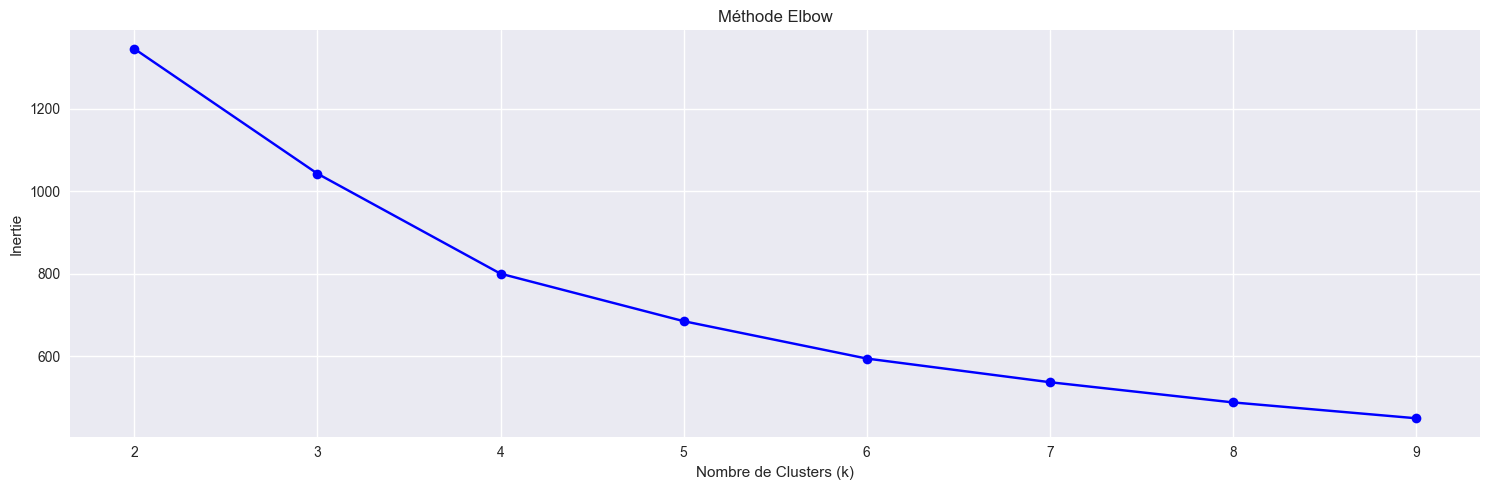

📊 Scores d'inertie par nombre de clusters:
k=2: 1345.446
k=3: 1042.653
k=4: 800.060
k=5: 684.903
k=6: 594.243
k=7: 536.868
k=8: 487.878
k=9: 449.421


In [85]:
# Méthode Elbow
inertias = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Visualisation
fig, ax1 = plt.subplots(figsize=(15, 5))

# Elbow Method
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Nombre de Clusters (k)')
ax1.set_ylabel('Inertie')
ax1.set_title('Méthode Elbow')
ax1.grid(True)

plt.tight_layout()
plt.show()

print("📊 Scores d'inertie par nombre de clusters:")
for k, score in zip(K_range, inertias):
    print(f"k={k}: {score:.3f}")

# Sauvegarde du modèle

In [86]:
MODEL_DIR = "../models/engagement_kmeans"
os.makedirs(MODEL_DIR, exist_ok=True)

# Sauvegarde des objets
joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler.joblib"))
joblib.dump(kmeans_model, os.path.join(MODEL_DIR, "kmeans.joblib"))
print(f"Model and scaler saved to {MODEL_DIR}")

Model and scaler saved to ../models/engagement_kmeans


# Test du model sauvegardé

In [87]:
# 1. Charger le scaler et le modèle
scaler = joblib.load(os.path.join(MODEL_DIR, "scaler.joblib"))
kmeans_model = joblib.load(os.path.join(MODEL_DIR, "kmeans.joblib"))

# 2. Appliquer le même pipeline sur de nouvelles données
df_new = pd.DataFrame({
    'tweet_counts_filtered': [10, 20, 19],
    'total_views': [100000, 200000, 1428758704],
    'likes_per_views': [0.002, 0.005, 0.00604],
    'retweets_per_views': [0.005, 0.002, 0.000783],
    'replies_per_views': [0.001, 0.003, 0.000603]
})

X_new = df_new[features]  # mêmes features que lors de l'entraînement
X_new_scaled = scaler.transform(X_new)  # important : utiliser transform(), PAS fit_transform()
predicted_labels = kmeans_model.predict(X_new_scaled)
df_new["predicted_cluster"] = predicted_labels

df_new

,tweet_counts_filtered,total_views,likes_per_views,retweets_per_views,replies_per_views,predicted_cluster
0,10,100000,0.00200,0.005000,0.001000,1
1,20,200000,0.00500,0.002000,0.003000,1
2,19,1428758704,0.00604,0.000783,0.000603,1
